In [1]:
import sys
sys.path.insert(1, '../')  # to load from any submodule in the repo

import numpy as np
import scipy as sp
import scipy.optimize
import matplotlib
import matplotlib.pyplot as plt
import scipy.spatial
import time
import itertools

import utils.dpcr_utils as utils

import torch
import torch.nn.functional as F

device = torch.device("cuda")

print('Using GPU : ' + str(torch.cuda.current_device()) + ' from ' + str(torch.cuda.device_count()) + ' devices')

Using GPU : 0 from 1 devices


In [59]:
def mergeClusters(pts, t, max_iter = 5):
    
    if (max_iter < 0):
        print ("reeached max iterations!")
        return pts

    N = pts.size(0)

    aa = torch.sum(pts**2, dim=1, keepdim=True)
    bb = torch.sum(pts**2, dim=1, keepdim=True)
    ab = torch.matmul(pts, pts.transpose(0, 1))

    D = aa - 2.0 * ab + bb.transpose(0, 1)

    idx_cluster = torch.arange(N)[torch.sum(D < t**2, dim=1) > 1]
    
    # if no clusters are found
    if (idx_cluster.size(0) == 0):
        print ("terminated mergeClusters! (%d iterations)" % (5 - max_iter))
        return pts    
    
    idx_non_cluster = torch.arange(N)[torch.sum(D < t**2, dim=1) < 2]
    
    
    plt.figure(figsize=(16,16))
    plt.axis('equal')
    plt.scatter(pts[idx_cluster].detach().cpu().numpy()[:,0], pts[idx_cluster].detach().cpu().numpy()[:,1])
    plt.scatter(pts[idx_non_cluster].detach().cpu().numpy()[:,0], pts[idx_non_cluster].detach().cpu().numpy()[:,1])
    
    E_N = (torch.max(D) + 1) * torch.eye(N, device=device)

    # compute for each point the index of the nearest point
    m = torch.argmin(D + E_N, dim = 1)
    
    # mark backrefs
    for i in range(m.size(0)):
        if m[i] > -1 and m[m[i]] == i:
            m[m[i]] = -1

    # keep only those points, where the distance to the nearest neighbor is less than t
    m = m[idx_cluster]
    
    # compute means of the cluster pairs
    clusters = 0.5 * (pts[idx_cluster[[m > -1]]] + pts[m[[m > -1]]])
    
    # generate new point cloud
    new_pts = torch.cat([pts[idx_non_cluster], clusters], dim=0)

    return mergeClusters(new_pts, t, max_iter = max_iter - 1)

terminated mergeClusters! (3 iterations)


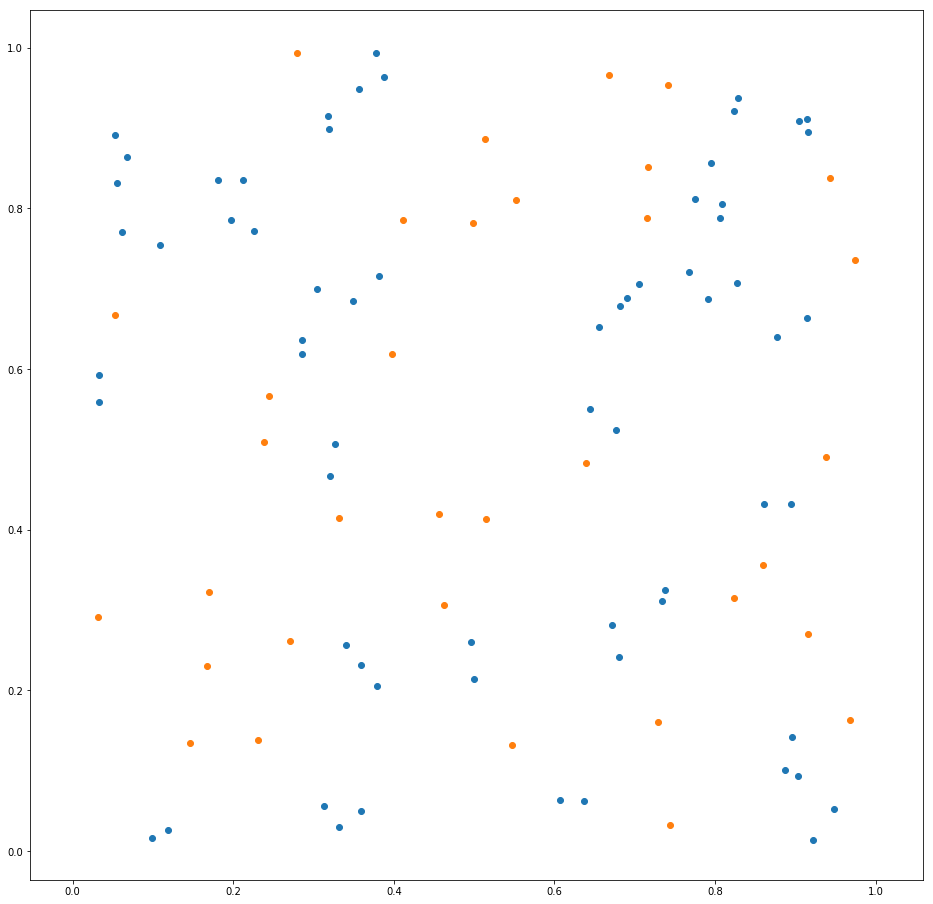

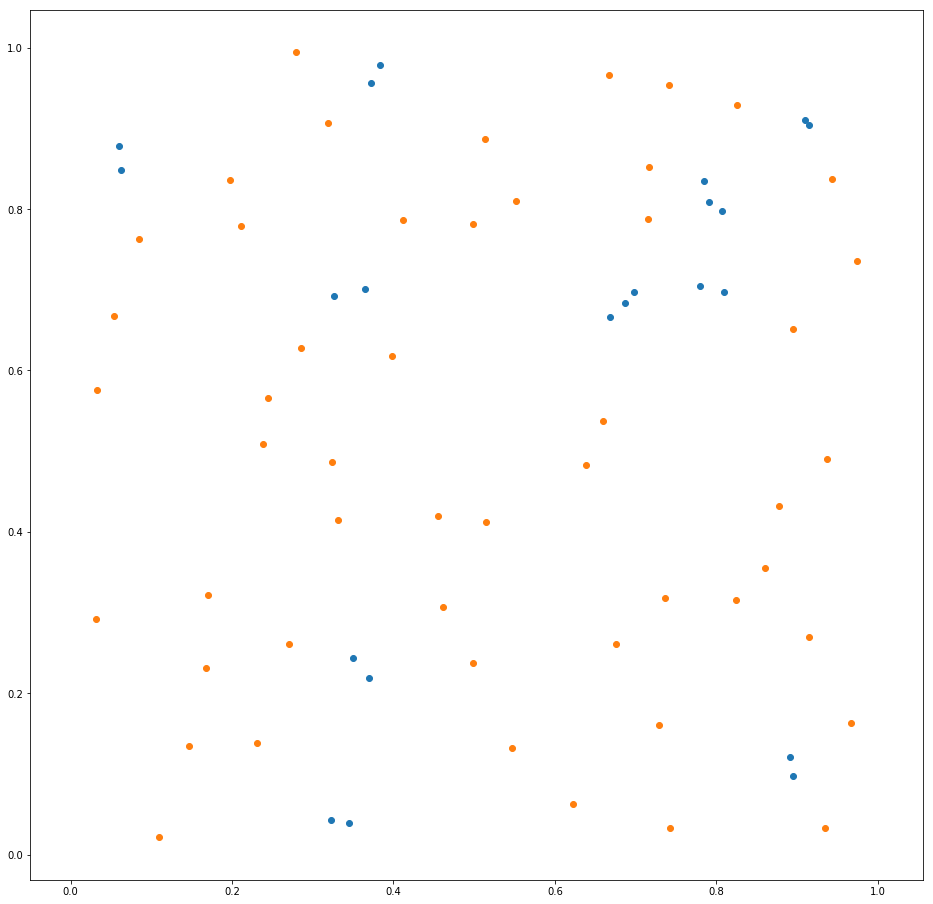

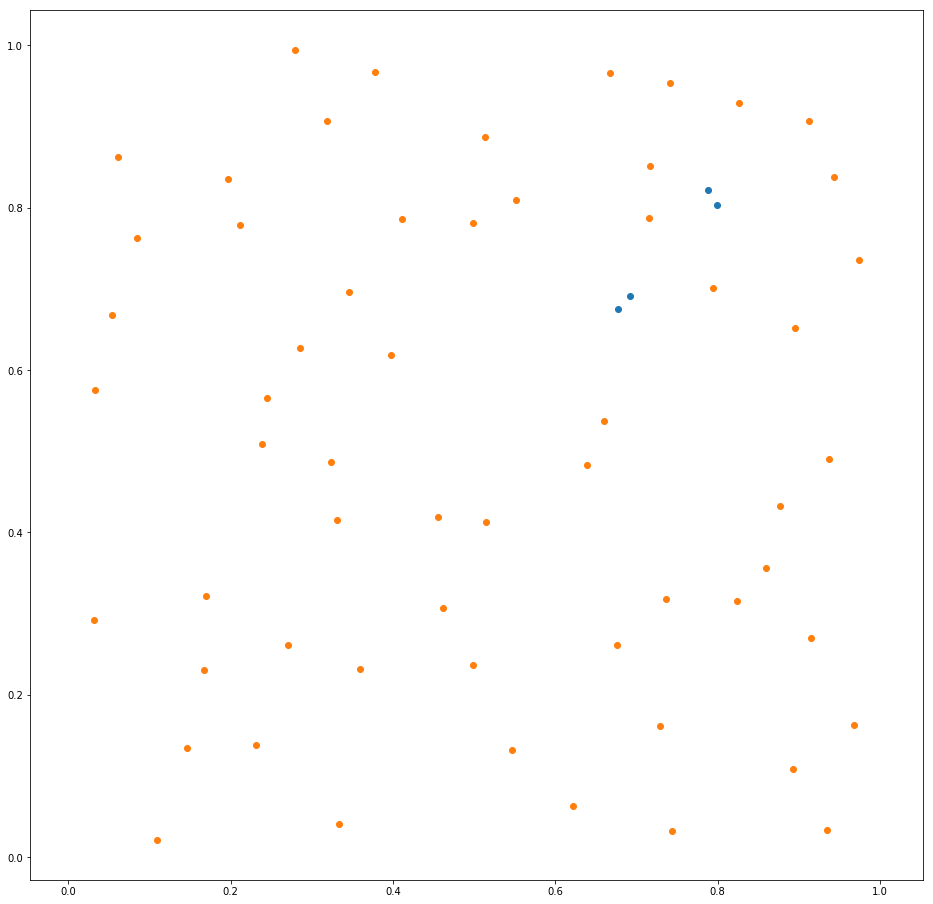

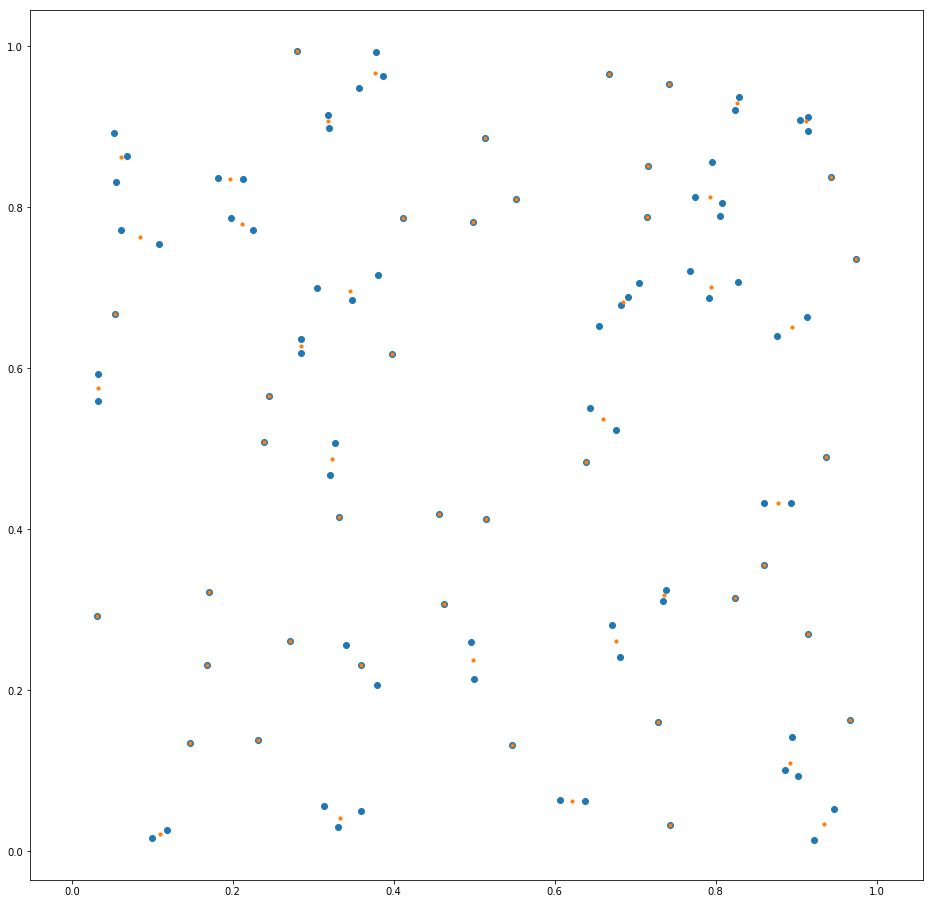

In [62]:
pts = np.random.rand(100,2)
pts_tensor = torch.from_numpy(pts).float().to(device)

new_pts = mergeClusters(pts_tensor, 0.05).detach().cpu().numpy()

plt.figure(figsize=(16,16))
plt.axis('equal')
plt.scatter(pts[:,0], pts[:,1])
plt.scatter(new_pts[:,0], new_pts[:,1], s=10)